In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Usar GPU
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # Usar CPU
    print("GPU no disponible, se utilizará la CPU")

GPU disponible: NVIDIA RTX A5500


In [3]:
# Input parameters
number_raster_layers = 9
number_epoch = 1000
radius_maps = "1050"

In [4]:
# Extract training and test info

df_train = pd.read_csv('Data/data_train_new.csv')
df_test = pd.read_csv('Data/data_test_new.csv')

rows_with_na = df_test.isna().any(axis=1)
indices_na = df_test.index[rows_with_na]
df_test = df_test.drop(index=indices_na)

In [5]:
number_training_sites = df_train.shape[0]
number_test_sites = df_test.shape[0]

print("Training sites:",number_training_sites)
print("Test sites:",number_test_sites)

Training sites: 817
Test sites: 170


In [6]:
# Extract training/test values and sites
train_values = df_train["log_vr_total"][0:number_training_sites]
train_sites = df_train["plot_id"][0:number_training_sites]

test_values = df_test["log_vr_total"][0:number_test_sites]
test_sites = df_test["plot_id"][0:number_test_sites]

In [7]:
# Turn the response variable into tensors
y_train = torch.tensor(np.repeat(train_values.values,4)) # We repeat each value 4 times because we included the raster and 3 rotations
y_test = torch.tensor(test_values.values) # same thing here
y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

In [8]:
# Estimate the minimum number of pixels per layer
min_rows_train = 100000
min_columns_train = 100000
min_rows_test = 100000
min_columns_test = 100000

for site in train_sites:
    
    # print(site)
    
    data1 = pd.read_csv('Data/Bare_df/radius_' + radius_maps + '/' + site + '.csv')
    data2 = pd.read_csv('Data/BuiltUp_df/radius_' + radius_maps + '/' + site + '.csv')
    
    rows_data1 = data1.shape[0]
    columns_data1 = data1.shape[1]
    
    if rows_data1 < min_rows_train:
        min_rows_train = rows_data1
        
    if columns_data1 < min_columns_train:
        min_columns_train = columns_data1

for site in test_sites:
    
    # print(site)
    
    data1 = pd.read_csv('Data/Bare_df/radius_' + radius_maps + '/' + site + '.csv')
    data2 = pd.read_csv('Data/BuiltUp_df/radius_' + radius_maps + '/' + site + '.csv')
    
    rows_data1 = data1.shape[0]
    columns_data1 = data1.shape[1]
    
    if rows_data1 < min_rows_test:
        min_rows_test = rows_data1
        
    if columns_data1 < min_columns_test:
        min_columns_test = columns_data1

        
print(min_rows_train)
print(min_columns_train)
print(min_rows_test)
print(min_columns_test)

number_pixels_layer = min(min_rows_train,min_rows_test,min_columns_train,min_columns_test)

if number_pixels_layer % 2 == 0:
    number_pixels_layer = number_pixels_layer - 1

print('Minimum number of pixels per (square) layer:', number_pixels_layer)

19
19
19
20
Minimum number of pixels per (square) layer: 19


In [9]:
def adjust_dataframe(data,number_pixels_layer):
    
    # turn nans into zeros
    data = data.fillna(0)
    
    rows_data = data.shape[0]
    columns_data = data.shape[1]
    
    # if the number of rows/columns are even we remove first row/column
    if rows_data % 2 == 0:
        data = data.drop([0])
        rows_data = data.shape[0]
    if columns_data % 2 == 0:
        data = data.drop(data.columns[0], axis=1)
        columns_data = data.shape[1]
        
    # Reduce images a matrices with number_pixels_layer x number_pixels_layer pixels
    
    while columns_data != number_pixels_layer:
        
        data = data.drop(data.columns[0], axis=1)
        columns_data = data.shape[1]
        data = data.drop(data.columns[(columns_data-1)], axis=1)
        columns_data = data.shape[1]
        
    while rows_data != number_pixels_layer:
        
        data = data.drop(data.index[[0, len(data)-1]])
        rows_data = data.shape[0]
        
    return data

In [10]:
def create_tensor_from_9_dataframe_layers(data1 ,data2, data3, data4, data5, data6, data7, data8, data9):
    
    # create tensor from data layer 
    tensor1 = torch.tensor(data1.values)
    tensor2 = torch.tensor(data2.values)
    tensor3 = torch.tensor(data3.values)
    tensor4 = torch.tensor(data4.values)
    tensor5 = torch.tensor(data5.values)
    tensor6 = torch.tensor(data6.values)
    tensor7 = torch.tensor(data7.values)
    tensor8 = torch.tensor(data8.values)
    tensor9 = torch.tensor(data9.values)
        
    return torch.stack((tensor1, tensor2, tensor3, tensor4, tensor5, tensor6, tensor7, tensor8, tensor9), dim=0)

def create_tensor_from_9_dataframe_layers_rotated_90_clock(data1 ,data2, data3, data4, data5, data6, data7, data8, data9):
    
    # rotate layers (90º, clockwise) 
    data1 = np.rot90(data1, k = -1)
    data2 = np.rot90(data2, k = -1)
    data3 = np.rot90(data3, k = -1)
    data4 = np.rot90(data4, k = -1)
    data5 = np.rot90(data5, k = -1)
    data6 = np.rot90(data6, k = -1)
    data7 = np.rot90(data7, k = -1)
    data8 = np.rot90(data8, k = -1)
    data9 = np.rot90(data9, k = -1)
    
    data1 = pd.DataFrame(data1.copy())
    data2 = pd.DataFrame(data2.copy())
    data3 = pd.DataFrame(data3.copy())
    data4 = pd.DataFrame(data4.copy())
    data5 = pd.DataFrame(data5.copy())
    data6 = pd.DataFrame(data6.copy())
    data7 = pd.DataFrame(data7.copy())
    data8 = pd.DataFrame(data8.copy())
    data9 = pd.DataFrame(data9.copy())
        
    return create_tensor_from_9_dataframe_layers(data1 ,data2, data3, data4, data5, data6, data7, data8, data9)

def create_tensor_from_9_dataframe_layers_rotated_90_counter(data1 ,data2, data3, data4, data5, data6, data7, data8, data9):
    
    # rotate layers (90º, counterclockwise) 
    data1 = np.rot90(data1, k = 1)
    data2 = np.rot90(data2, k = 1)
    data3 = np.rot90(data3, k = 1)
    data4 = np.rot90(data4, k = 1)
    data5 = np.rot90(data5, k = 1)
    data6 = np.rot90(data6, k = 1)
    data7 = np.rot90(data7, k = 1)
    data8 = np.rot90(data8, k = 1)
    data9 = np.rot90(data9, k = 1)
    
    data1 = pd.DataFrame(data1.copy())
    data2 = pd.DataFrame(data2.copy())
    data3 = pd.DataFrame(data3.copy())
    data4 = pd.DataFrame(data4.copy())
    data5 = pd.DataFrame(data5.copy())
    data6 = pd.DataFrame(data6.copy())
    data7 = pd.DataFrame(data7.copy())
    data8 = pd.DataFrame(data8.copy())
    data9 = pd.DataFrame(data9.copy())
        
    return create_tensor_from_9_dataframe_layers(data1 ,data2, data3, data4, data5, data6, data7, data8, data9)

def create_tensor_from_9_dataframe_layers_rotated_180(data1 ,data2, data3, data4, data5, data6, data7, data8, data9):
    
     # create tensor from data layer 
    data1 = np.rot90(np.rot90(data1, k = -1), k = -1)
    data2 = np.rot90(np.rot90(data2, k = -1), k = -1)
    data3 = np.rot90(np.rot90(data3, k = -1), k = -1)
    data4 = np.rot90(np.rot90(data4, k = -1), k = -1)
    data5 = np.rot90(np.rot90(data5, k = -1), k = -1)
    data6 = np.rot90(np.rot90(data6, k = -1), k = -1)
    data7 = np.rot90(np.rot90(data7, k = -1), k = -1)
    data8 = np.rot90(np.rot90(data8, k = -1), k = -1)
    data9 = np.rot90(np.rot90(data9, k = -1), k = -1)
    
    data1 = pd.DataFrame(data1.copy())
    data2 = pd.DataFrame(data2.copy())
    data3 = pd.DataFrame(data3.copy())
    data4 = pd.DataFrame(data4.copy())
    data5 = pd.DataFrame(data5.copy())
    data6 = pd.DataFrame(data6.copy())
    data7 = pd.DataFrame(data7.copy())
    data8 = pd.DataFrame(data8.copy())
    data9 = pd.DataFrame(data9.copy())
        
    return create_tensor_from_9_dataframe_layers(data1 ,data2, data3, data4, data5, data6, data7, data8, data9)

In [11]:
# Create a training tensor
for site in train_sites:
    
    # print(site)
    
    data1 = pd.read_csv('Data/Bare_df/radius_'+ radius_maps +'/' + site + '.csv')
    data2 = pd.read_csv('Data/BuiltUp_df/radius_'+ radius_maps +'/' + site + '.csv')
    data3 = pd.read_csv('Data/Crops_df/radius_'+ radius_maps +'/' + site + '.csv')
    data4 = pd.read_csv('Data/Grass_df/radius_'+ radius_maps +'/' + site + '.csv')
    data5 = pd.read_csv('Data/MossLichen_df/radius_'+ radius_maps +'/' + site + '.csv')
    data6 = pd.read_csv('Data/PermanentWater_df/radius_'+ radius_maps +'/' + site + '.csv')
    data7 = pd.read_csv('Data/SeasonalWater_df/radius_'+ radius_maps +'/' + site + '.csv')
    data8 = pd.read_csv('Data/Shrub_df/radius_'+ radius_maps +'/' + site + '.csv')
    data9 = pd.read_csv('Data/Tree_df/radius_'+ radius_maps +'/' + site + '.csv')
    
    data1 = adjust_dataframe(data1,number_pixels_layer)
    data2 = adjust_dataframe(data2,number_pixels_layer)
    data3 = adjust_dataframe(data3,number_pixels_layer)
    data4 = adjust_dataframe(data4,number_pixels_layer)
    data5 = adjust_dataframe(data5,number_pixels_layer)
    data6 = adjust_dataframe(data6,number_pixels_layer)
    data7 = adjust_dataframe(data7,number_pixels_layer)
    data8 = adjust_dataframe(data8,number_pixels_layer)
    data9 = adjust_dataframe(data9,number_pixels_layer)

    # Create tensor from layers
    tensor_9capas = create_tensor_from_9_dataframe_layers(data1 ,data2, data3, data4, data5, data6, data7, data8, data9)
    
    # Create tensor from layers rotated 90º clockwise
    tensor_9capas_rotated_90_clock = create_tensor_from_9_dataframe_layers_rotated_90_clock(data1 ,data2, data3, data4, data5, data6, data7, data8, data9)
    
    # Create tensor from layers rotated 90º counterclockwise
    tensor_9capas_rotated_90_counter = create_tensor_from_9_dataframe_layers_rotated_90_counter(data1 ,data2, data3, data4, data5, data6, data7, data8, data9)
    
    # Create tensor from layers rotated 180º
    tensor_9capas_rotated_180 = create_tensor_from_9_dataframe_layers_rotated_180(data1 ,data2, data3, data4, data5, data6, data7, data8, data9)
    
    # print(tensor_9capas.shape)

    tensor_9capas = tensor_9capas.unsqueeze(0)
    tensor_9capas_rotated_90_clock = tensor_9capas_rotated_90_clock.unsqueeze(0)
    tensor_9capas_rotated_90_counter = tensor_9capas_rotated_90_counter.unsqueeze(0)
    tensor_9capas_rotated_180 = tensor_9capas_rotated_180.unsqueeze(0)
    
    # print(tensor_9capas.shape)
    
    if site == train_sites.iloc[0]:
        
        training_tensor = tensor_9capas
        training_tensor = torch.cat((training_tensor, tensor_9capas_rotated_90_clock), dim=0)
        training_tensor = torch.cat((training_tensor, tensor_9capas_rotated_90_counter), dim=0)
        training_tensor = torch.cat((training_tensor, tensor_9capas_rotated_180), dim=0)
        
    else:
        
        training_tensor = torch.cat((training_tensor, tensor_9capas), dim=0)
        training_tensor = torch.cat((training_tensor, tensor_9capas_rotated_90_clock), dim=0)
        training_tensor = torch.cat((training_tensor, tensor_9capas_rotated_90_counter), dim=0)
        training_tensor = torch.cat((training_tensor, tensor_9capas_rotated_180), dim=0)
        
    
print(training_tensor.shape)

torch.Size([3268, 9, 19, 19])


In [12]:
# Create a test tensor
for site in test_sites:
    
    # print(site)
    
    data1 = pd.read_csv('Data/Bare_df/radius_'+ radius_maps +'/' + site + '.csv')
    data2 = pd.read_csv('Data/BuiltUp_df/radius_'+ radius_maps +'/' + site + '.csv')
    data3 = pd.read_csv('Data/Crops_df/radius_'+ radius_maps +'/' + site + '.csv')
    data4 = pd.read_csv('Data/Grass_df/radius_'+ radius_maps +'/' + site + '.csv')
    data5 = pd.read_csv('Data/MossLichen_df/radius_'+ radius_maps +'/' + site + '.csv')
    data6 = pd.read_csv('Data/PermanentWater_df/radius_'+ radius_maps +'/' + site + '.csv')
    data7 = pd.read_csv('Data/SeasonalWater_df/radius_'+ radius_maps +'/' + site + '.csv')
    data8 = pd.read_csv('Data/Shrub_df/radius_'+ radius_maps +'/' + site + '.csv')
    data9 = pd.read_csv('Data/Tree_df/radius_'+ radius_maps +'/' + site + '.csv')
    
    data1 = adjust_dataframe(data1,number_pixels_layer)
    data2 = adjust_dataframe(data2,number_pixels_layer)
    data3 = adjust_dataframe(data3,number_pixels_layer)
    data4 = adjust_dataframe(data4,number_pixels_layer)
    data5 = adjust_dataframe(data5,number_pixels_layer)
    data6 = adjust_dataframe(data6,number_pixels_layer)
    data7 = adjust_dataframe(data7,number_pixels_layer)
    data8 = adjust_dataframe(data8,number_pixels_layer)
    data9 = adjust_dataframe(data9,number_pixels_layer)

    # Create tensor from layers
    tensor_9capas = create_tensor_from_9_dataframe_layers(data1 ,data2, data3, data4, data5, data6, data7, data8, data9)
    
    # Create tensor from layers rotated 90º clockwise
    # tensor_9capas_rotated_90_clock = create_tensor_from_9_dataframe_layers_rotated_90_clock(data1 ,data2, data3, data4, data5, data6, data7, data8, data9)
    
    # Create tensor from layers rotated 90º counterclockwise
    # tensor_9capas_rotated_90_counter = create_tensor_from_9_dataframe_layers_rotated_90_counter(data1 ,data2, data3, data4, data5, data6, data7, data8, data9)
    
    # Create tensor from layers rotated 180º
    # tensor_9capas_rotated_180 = create_tensor_from_9_dataframe_layers_rotated_180(data1 ,data2, data3, data4, data5, data6, data7, data8, data9)
    
    # print(tensor_9capas.shape)

    tensor_9capas = tensor_9capas.unsqueeze(0)
    # tensor_9capas_rotated_90_clock = tensor_9capas_rotated_90_clock.unsqueeze(0)
    # tensor_9capas_rotated_90_counter = tensor_9capas_rotated_90_counter.unsqueeze(0)
    # tensor_9capas_rotated_180 = tensor_9capas_rotated_180.unsqueeze(0)
    
    # print(tensor_9capas.shape)
    
    if site == test_sites.iloc[0]:
        
        test_tensor = tensor_9capas
        # test_tensor = torch.cat((test_tensor, tensor_9capas_rotated_90_clock), dim=0)
        # test_tensor = torch.cat((test_tensor, tensor_9capas_rotated_90_counter), dim=0)
        # test_tensor = torch.cat((test_tensor, tensor_9capas_rotated_180), dim=0)
        
    else:
        
        test_tensor = torch.cat((test_tensor, tensor_9capas), dim=0)
        # test_tensor = torch.cat((test_tensor, tensor_9capas_rotated_90_clock), dim=0)
        # test_tensor = torch.cat((test_tensor, tensor_9capas_rotated_90_counter), dim=0)
        # test_tensor = torch.cat((test_tensor, tensor_9capas_rotated_180), dim=0)
        

print(test_tensor.shape)

torch.Size([170, 9, 19, 19])


In [1]:
# Model definition
dropout_rate = 0.5

class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv2d(number_raster_layers, 16, kernel_size=3, stride=1, padding=1)
        self.selu1 = nn.SELU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.selu2 = nn.SELU()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.selu3 = nn.SELU()
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.selu4 = nn.SELU()
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.selu5 = nn.SELU()
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.selu6 = nn.SELU()
        self.conv7 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.selu7 = nn.SELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1024 * number_pixels_layer * number_pixels_layer, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.selu1(x)
        x = self.conv2(x)
        x = self.selu2(x)
        x = self.conv3(x)
        x = self.selu3(x)
        x = self.conv4(x)
        x = self.selu4(x)
        x = self.conv5(x)
        x = self.selu5(x)
        x = self.conv6(x)
        x = self.selu6(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = CNNRegressor()

NameError: name 'nn' is not defined

In [14]:
# DO NOT RUN: COMPUTERS MEMORY RUNS OUT
## Check GPU availability
#if torch.cuda.is_available():
#    device = torch.device("cuda")
#    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
#else:
#    device = torch.device("cpu")
#    print("GPU no disponible, se utilizará la CPU")

## Create a model and send it to GPUs
#model = CNNRegressor().to(device)

## Send data to GPUs
#training_tensor = training_tensor.to(device)
#y_train = y_train.to(device)

In [15]:
# Loss function and optimization
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [17]:
import torch.nn.functional as F

# Training
# for epoch in range(number_epoch):
#     optimizer.zero_grad()
#     outputs = model(training_tensor.to(torch.float))
#     loss = criterion(outputs, y_train.to(torch.float))
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch [{epoch+1}/{number_epoch}], Loss: {loss.item()}')

for epoch in range(number_epoch):
    optimizer.zero_grad()
    outputs = model(training_tensor.to(torch.float))
    loss = criterion(outputs, y_train.to(torch.float))
    
    # L2 regularization
    l2_lambda = 0.01  # L2 regularization factor
    l2_regularization = torch.tensor(0.)  # init L2 regularization factor

    for param in model.parameters():
        l2_regularization += torch.norm(param, 9)  # add L2 norm of each parameter

    loss += l2_lambda * l2_regularization  # add L2 reg to total loss

    
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{number_epoch}], Loss: {loss.item()}')
    
    #torch.cuda.empty_cache()

Epoch [1/1000], Loss: 8.105806350708008
Epoch [2/1000], Loss: 1689.7183837890625
Epoch [3/1000], Loss: 10090.1083984375
Epoch [4/1000], Loss: 8904.916015625
Epoch [5/1000], Loss: 13525.708984375
Epoch [6/1000], Loss: 5417.8994140625
Epoch [7/1000], Loss: 5369.53564453125
Epoch [8/1000], Loss: 1613.470458984375
Epoch [9/1000], Loss: 232.05918884277344
Epoch [10/1000], Loss: 520.576416015625
Epoch [11/1000], Loss: 1377.2115478515625
Epoch [12/1000], Loss: 1623.9150390625
Epoch [13/1000], Loss: 778.6499633789062
Epoch [14/1000], Loss: 1569.615966796875
Epoch [15/1000], Loss: 810.7725830078125
Epoch [16/1000], Loss: 962.0589599609375
Epoch [17/1000], Loss: 96.543212890625
Epoch [18/1000], Loss: 74.34648132324219
Epoch [19/1000], Loss: 337.4402770996094
Epoch [20/1000], Loss: 94.311767578125
Epoch [21/1000], Loss: 242.4776153564453
Epoch [22/1000], Loss: 193.2381134033203
Epoch [23/1000], Loss: 196.53236389160156
Epoch [24/1000], Loss: 119.50946044921875
Epoch [25/1000], Loss: 248.093017578

Epoch [198/1000], Loss: 2.3787291049957275
Epoch [199/1000], Loss: 2.383944272994995
Epoch [200/1000], Loss: 2.3372669219970703
Epoch [201/1000], Loss: 2.461604595184326
Epoch [202/1000], Loss: 2.4175801277160645
Epoch [203/1000], Loss: 2.3481173515319824
Epoch [204/1000], Loss: 2.4137113094329834
Epoch [205/1000], Loss: 2.380213737487793
Epoch [206/1000], Loss: 2.418241024017334
Epoch [207/1000], Loss: 2.3714005947113037
Epoch [208/1000], Loss: 2.41947603225708
Epoch [209/1000], Loss: 2.4405264854431152
Epoch [210/1000], Loss: 2.4020254611968994
Epoch [211/1000], Loss: 2.3059442043304443
Epoch [212/1000], Loss: 2.4526660442352295
Epoch [213/1000], Loss: 2.384228229522705
Epoch [214/1000], Loss: 2.359931707382202
Epoch [215/1000], Loss: 2.394305467605591
Epoch [216/1000], Loss: 2.4427247047424316
Epoch [217/1000], Loss: 2.2798759937286377
Epoch [218/1000], Loss: 2.3467938899993896
Epoch [219/1000], Loss: 2.309236526489258
Epoch [220/1000], Loss: 2.3218913078308105
Epoch [221/1000], Los

Epoch [391/1000], Loss: 1.979102611541748
Epoch [392/1000], Loss: 1.9099478721618652
Epoch [393/1000], Loss: 1.9604969024658203
Epoch [394/1000], Loss: 2.084350824356079
Epoch [395/1000], Loss: 1.9745675325393677
Epoch [396/1000], Loss: 1.9994933605194092
Epoch [397/1000], Loss: 1.9742337465286255
Epoch [398/1000], Loss: 1.9451045989990234
Epoch [399/1000], Loss: 1.948326826095581
Epoch [400/1000], Loss: 1.9866437911987305
Epoch [401/1000], Loss: 1.9458730220794678
Epoch [402/1000], Loss: 2.0137922763824463
Epoch [403/1000], Loss: 1.865907907485962
Epoch [404/1000], Loss: 1.9460369348526
Epoch [405/1000], Loss: 1.9378411769866943
Epoch [406/1000], Loss: 1.9503875970840454
Epoch [407/1000], Loss: 1.933268666267395
Epoch [408/1000], Loss: 1.937899112701416
Epoch [409/1000], Loss: 1.9909471273422241
Epoch [410/1000], Loss: 1.9631247520446777
Epoch [411/1000], Loss: 1.9368013143539429
Epoch [412/1000], Loss: 1.9415446519851685
Epoch [413/1000], Loss: 1.9410715103149414
Epoch [414/1000], Lo

Epoch [584/1000], Loss: 1.6869702339172363
Epoch [585/1000], Loss: 1.7490006685256958
Epoch [586/1000], Loss: 1.716437578201294
Epoch [587/1000], Loss: 1.7523053884506226
Epoch [588/1000], Loss: 1.7376000881195068
Epoch [589/1000], Loss: 1.74085533618927
Epoch [590/1000], Loss: 1.7009774446487427
Epoch [591/1000], Loss: 1.6836880445480347
Epoch [592/1000], Loss: 1.6919026374816895
Epoch [593/1000], Loss: 1.727492332458496
Epoch [594/1000], Loss: 1.716562032699585
Epoch [595/1000], Loss: 1.6878525018692017
Epoch [596/1000], Loss: 1.6957770586013794
Epoch [597/1000], Loss: 1.6944022178649902
Epoch [598/1000], Loss: 1.6716467142105103
Epoch [599/1000], Loss: 1.725175142288208
Epoch [600/1000], Loss: 1.6736547946929932
Epoch [601/1000], Loss: 1.731028437614441
Epoch [602/1000], Loss: 1.7224206924438477
Epoch [603/1000], Loss: 1.754661202430725
Epoch [604/1000], Loss: 1.7081470489501953
Epoch [605/1000], Loss: 1.6607391834259033
Epoch [606/1000], Loss: 1.7092032432556152
Epoch [607/1000], L

Epoch [776/1000], Loss: 1.4995437860488892
Epoch [777/1000], Loss: 1.628031611442566
Epoch [778/1000], Loss: 1.6765238046646118
Epoch [779/1000], Loss: 1.6854785680770874
Epoch [780/1000], Loss: 1.6201906204223633
Epoch [781/1000], Loss: 1.5479345321655273
Epoch [782/1000], Loss: 1.5356999635696411
Epoch [783/1000], Loss: 1.6569491624832153
Epoch [784/1000], Loss: 1.7132285833358765
Epoch [785/1000], Loss: 1.812720775604248
Epoch [786/1000], Loss: 1.8120079040527344
Epoch [787/1000], Loss: 1.7500121593475342
Epoch [788/1000], Loss: 1.6684850454330444
Epoch [789/1000], Loss: 1.5298776626586914
Epoch [790/1000], Loss: 1.5193471908569336
Epoch [791/1000], Loss: 1.4796477556228638
Epoch [792/1000], Loss: 1.5252469778060913
Epoch [793/1000], Loss: 1.5028953552246094
Epoch [794/1000], Loss: 1.4549773931503296
Epoch [795/1000], Loss: 1.51197350025177
Epoch [796/1000], Loss: 1.4571095705032349
Epoch [797/1000], Loss: 1.4595692157745361
Epoch [798/1000], Loss: 1.5437121391296387
Epoch [799/1000

Epoch [968/1000], Loss: 1.3589954376220703
Epoch [969/1000], Loss: 1.3713948726654053
Epoch [970/1000], Loss: 1.3942151069641113
Epoch [971/1000], Loss: 1.3719996213912964
Epoch [972/1000], Loss: 1.3830187320709229
Epoch [973/1000], Loss: 1.3489305973052979
Epoch [974/1000], Loss: 1.3895647525787354
Epoch [975/1000], Loss: 1.3838728666305542
Epoch [976/1000], Loss: 1.3675086498260498
Epoch [977/1000], Loss: 1.385542869567871
Epoch [978/1000], Loss: 1.3540823459625244
Epoch [979/1000], Loss: 1.350003719329834
Epoch [980/1000], Loss: 1.3478384017944336
Epoch [981/1000], Loss: 1.413230299949646
Epoch [982/1000], Loss: 1.3719708919525146
Epoch [983/1000], Loss: 1.3862013816833496
Epoch [984/1000], Loss: 1.3460752964019775
Epoch [985/1000], Loss: 1.4120292663574219
Epoch [986/1000], Loss: 1.3466191291809082
Epoch [987/1000], Loss: 1.3435053825378418
Epoch [988/1000], Loss: 1.3339691162109375
Epoch [989/1000], Loss: 1.3617280721664429
Epoch [990/1000], Loss: 1.3765305280685425
Epoch [991/100

In [20]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# Model eval
y_pred = model(test_tensor.to(torch.float))
y_true = y_test.to(torch.float)

# MSE
mse = nn.MSELoss()
mse_loss = mse(y_pred, y_true)
print("MSE:", mse_loss.item())

# RMSE
rmse_loss = torch.sqrt(mse_loss)
print("RMSE:", rmse_loss.item())

# MAE
mae_loss = torch.mean(torch.abs(y_pred - y_true))
print("MAE:", mae_loss.item())

y_true_array = y_true.flatten().tolist()
y_pred_array = y_pred.flatten().tolist()

# R^2
r2 = r2_score(y_true_array, y_pred_array)
print("R^2:", r2)

# Pearson
corr, p_value_r = pearsonr(y_true_array, y_pred_array)
print("Pearson's r:", corr)
print("p-value (Pearson):", p_value_r)
print("Sanity check: r * r?", corr*corr)
print("Sanity check: r2 - r * r = 0?", r2 == corr*corr, r2 - corr*corr)

# Spearman
rho, p_value_rho = spearmanr(y_true_array, y_pred_array)
print("Spearman's rho:", rho)
print("p-value:", p_value_rho)

MSE: 2.30431866645813
RMSE: 1.517998218536377
MAE: 1.222743272781372
R^2: 0.04468607250552148
Pearson's r: 0.3839983626402441
p-value (Pearson): 2.3489689929693057e-07
Sanity check: r * r? 0.14745474251038843
Sanity check: r2 - r * r = 0? False -0.10276867000486695
Spearman's rho: 0.4112360367192335
p-value: 2.536413990160456e-08


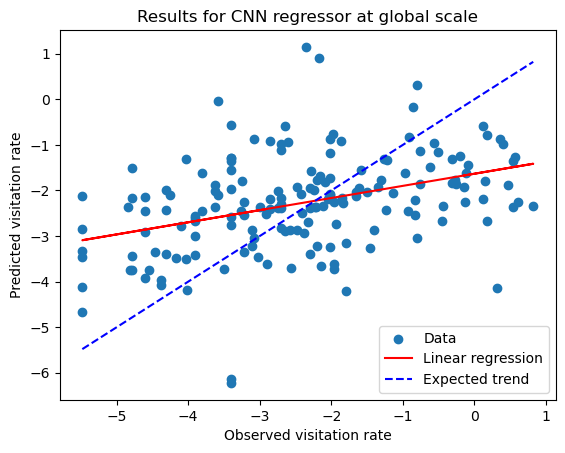

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# fit a regression line with numpy
coef = np.polyfit(y_true_array, y_pred_array, 1)
poly1d_fn = np.poly1d(coef)

# create a scatter plot with regression line
plt.scatter(y_true_array, y_pred_array, label='Data')
plt.plot(y_true_array, poly1d_fn(y_true_array), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_true_array), sorted(y_true_array), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for CNN regressor at global scale')

# show legend
plt.legend()

# show plot
plt.show()

In [22]:
# Save the fitted model
path_model = 'global_regressor_V0.pth'
torch.save(model.state_dict(), path_model)




In [20]:
# Load the fitted model
#load_model = MiModelo()
load_model.load_state_dict(torch.load(path_model))
load_model.eval()  # To eval the loaded model


NameError: name 'MiModelo' is not defined